### Time-frequency on simulated data 
- Multitapers
- Morlet
- Stockwell

Demonstrates the different time-frequency estimation methods on simulated data. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mne import create_info,EpochsArray
from mne.baseline import rescale
from mne.time_frequency import tfr_multitaper,tfr_stockwell
from mne.time_frequency import tfr_morlet,tfr_array_morlet

### Simulate Data

In [2]:
sfreq = 1000.0
ch_names = ['SIM0001','SIM0002'] ## 命名模拟的通道名
ch_types = ['grad','grad'] ## 定义对应通道的类型
info = create_info(ch_names=ch_names,sfreq=sfreq,ch_types=ch_types)

In [3]:
info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | SIM0001, SIM0002
    chs : list | 2 items (GRAD: 2)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 500.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 2
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>

In [4]:
n_times = 1024  # Just over 1 second epochs
n_epochs = 40
seed = 42
rng = np.random.RandomState(seed)
noise = rng.randn(n_epochs, len(ch_names), n_times)

In [7]:
noise.shape

(40, 2, 1024)

In [8]:
# Add a 50 Hz sinusoidal burst to the noise and ramp it.
t = np.arange(n_times, dtype=np.float) / sfreq
signal = np.sin(np.pi * 2. * 50. * t)  # 50 Hz sinusoid signal
signal[np.logical_or(t < 0.45, t > 0.55)] = 0.  # Hard windowing
on_time = np.logical_and(t >= 0.45, t <= 0.55)
signal[on_time] *= np.hanning(on_time.sum())  # Ramping
data = noise + signal

In [13]:
signal.shape

(1024,)

In [14]:
on_time

array([False, False, False, ..., False, False, False], dtype=bool)

In [15]:
reject = dict(grad=4000)
events = np.empty((n_epochs, 3), dtype=int)
first_event_sample = 100
event_id = dict(sin50hz=1)
for k in range(n_epochs):
    events[k, :] = first_event_sample + k * n_times, 0, event_id['sin50hz']


In [16]:
event_id

{'sin50hz': 1}

In [17]:
events

array([[  100,     0,     1],
       [ 1124,     0,     1],
       [ 2148,     0,     1],
       [ 3172,     0,     1],
       [ 4196,     0,     1],
       [ 5220,     0,     1],
       [ 6244,     0,     1],
       [ 7268,     0,     1],
       [ 8292,     0,     1],
       [ 9316,     0,     1],
       [10340,     0,     1],
       [11364,     0,     1],
       [12388,     0,     1],
       [13412,     0,     1],
       [14436,     0,     1],
       [15460,     0,     1],
       [16484,     0,     1],
       [17508,     0,     1],
       [18532,     0,     1],
       [19556,     0,     1],
       [20580,     0,     1],
       [21604,     0,     1],
       [22628,     0,     1],
       [23652,     0,     1],
       [24676,     0,     1],
       [25700,     0,     1],
       [26724,     0,     1],
       [27748,     0,     1],
       [28772,     0,     1],
       [29796,     0,     1],
       [30820,     0,     1],
       [31844,     0,     1],
       [32868,     0,     1],
       [33

In [20]:
epochs = EpochsArray(data=data,info=info,events=events,event_id=event_id,reject=reject)
epochs

40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<EpochsArray  |   40 events (all good), 0 - 1.023 sec, baseline off, ~651 kB, data loaded,
 'sin50hz': 40>

Need more than one channel to make topography for grad. Disabling interactivity.


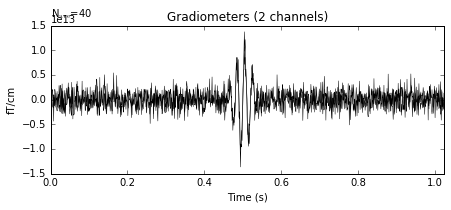

In [22]:
epochs.average().plot()

### Calculate a time-frequency representation (TFR)
- [mne.time_frequency.tfr_multitaper()](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_multitaper.html#mne.time_frequency.tfr_multitaper)
- [mne.time_frequency.tfr_stockwell()](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_stockwell.html#mne.time_frequency.tfr_stockwell)
- [mne.time_frequency.tfr_morlet()](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_morlet.html#mne.time_frequency.tfr_morlet)

#### use the multitaper method for calculating the TFR
-  Creates several orthogonal tapering windows in the TFR estimation, which reduces variance.
- You can trade time resolution or frequency resolution or both in order to get a reduction in variance.

In [26]:
freqs = np.arange(5.,100.,3.)
vmin,vmax = -3.,3. # Define our color limits.
freqs

array([  5.,   8.,  11.,  14.,  17.,  20.,  23.,  26.,  29.,  32.,  35.,
        38.,  41.,  44.,  47.,  50.,  53.,  56.,  59.,  62.,  65.,  68.,
        71.,  74.,  77.,  80.,  83.,  86.,  89.,  92.,  95.,  98.])

#### (1) Least smoothing (most variance/background fluctuations).
-  Baseline Correct 

Applying baseline correction (mode: mean)


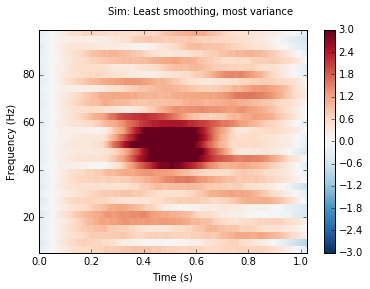

Applying baseline correction (mode: mean)


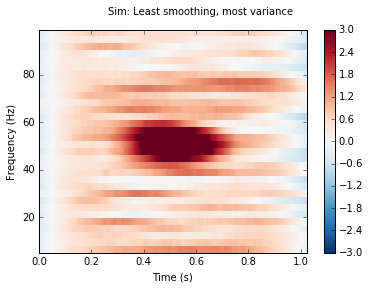

In [31]:
n_cycles = freqs/2.
time_bandwidth = 2.0  # Least possible frequency-smoothing (1 taper)
# tfr_multitaper():
# Return:
    # power : AverageTFR | EpochsTFR
    # The averaged or single-trial power.
    #itc : AverageTFR | EpochsTFR
    #The inter-trial coherence (ITC). Only returned if return_itc is True.
power = tfr_multitaper(epochs,freqs=freqs,n_cycles=n_cycles,
                      time_bandwidth=time_bandwidth,return_itc=False)
# Plot results. 
## Baseline Correct based on first 100ms.

# picks: The indices of the channels to plot, one figure per channel. If None, plot the across-channel average. 
#         If None, all available channels are displayed.
power.plot(picks=[0],baseline=(0.,0.1),mode='mean',vmin=vmin,vmax=vmax,
          title='Sim: Least smoothing, most variance');
power.plot(picks=[1],baseline=(0.,0.1),mode='mean',vmin=vmin,vmax=vmax,
          title='Sim: Least smoothing, most variance');

### [AverageTFR]( https://martinos.org/mne/stable/generated/mne.time_frequency.AverageTFR.html):
Attributes:	
    info : instance of Info
    Measurement info.

    ch_names : list
    Channel names.

    nave : int
    Number of averaged epochs.

    data : ndarray, shape (n_channels, n_freqs, n_times)
    The data array.

    times : ndarray, shape (n_times,)
    The time values in seconds.

    freqs : ndarray, shape (n_freqs,)
    The frequencies in Hz.

    comment : string
    Comment on dataset. Can be the condition.

    method : str | None, defaults to None
    Comment on the method used to compute the data, e.g., morlet wavelet.

In [34]:
print("power",power)
print("power info",power.info)

('power', <AverageTFR  |  time : [0.000000, 1.023000], freq : [5.000000, 98.000000], nave : 40, channels : 2, ~523 kB>)
('power info', <Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | SIM0001, SIM0002
    chs : list | 2 items (GRAD: 2)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 500.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 2
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
   

#### (2) Less frequency smoothing, more time smoothing.

Applying baseline correction (mode: mean)


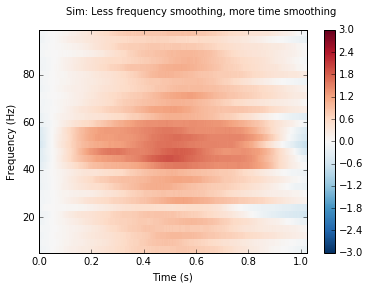

In [46]:
n_cycles = freqs  # Increase time-window length to 1 second.
time_bandwidth = 4.0  # Same frequency-smoothing as (1) 3 tapers.
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
# Plot results. Baseline correct based on first 100 ms.
power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
           title='Sim: Less frequency smoothing, more time smoothing');

#### (3) Less time smoothing, more frequency smoothing.

Applying baseline correction (mode: mean)


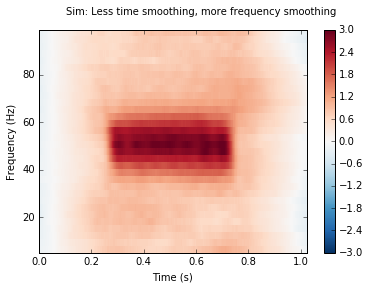

In [47]:
n_cycles = freqs / 2.
time_bandwidth = 8.0  # Same time-smoothing as (1), 7 tapers.
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
# Plot results. Baseline correct based on first 100 ms.
power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
           title='Sim: Less time smoothing, more frequency smoothing');

### Stockwell (S) transform

Stockwell uses a Gaussian window to balance temporal and spectral resolution. Importantly, frequency bands are phase-normalized, hence strictly comparable with regard to timing, and, the input signal can be recoverd from the transform in a lossless way if we disregard numerical errors. In this case, we control the spectral / temporal resolution by specifying different widths of the gaussian window using the width parameter.

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


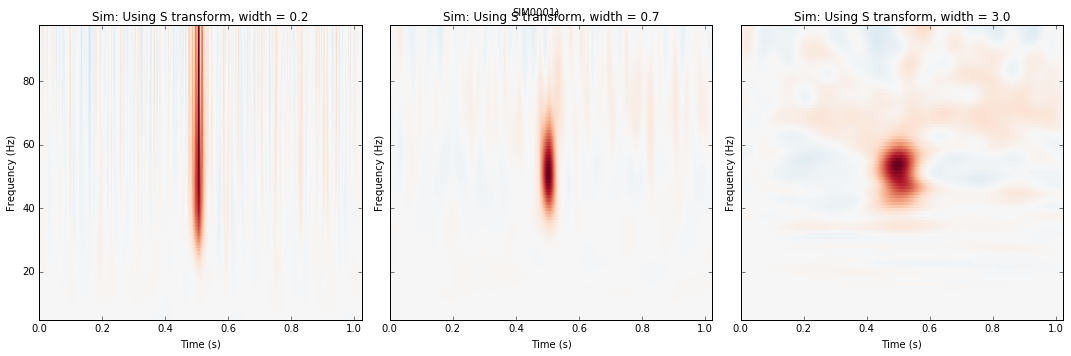

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fmin, fmax = freqs[[0, -1]]
for width, ax in zip((0.2, .7, 3.0), axs):
    power = tfr_stockwell(epochs, fmin=fmin, fmax=fmax, width=width)
    power.plot([0], baseline=(0., 0.1), mode='mean', axes=ax, show=False,
               colorbar=False)
    ax.set_title('Sim: Using S transform, width = {:0.1f}'.format(width))
plt.tight_layout()

### Morlet Wavelets

Finally, show the TFR using morlet wavelets, which are a sinusoidal wave with a gaussian envelope. **We can control the balance between spectral and temporal resolution with the n_cycles parameter**, which defines the number of cycles to include in the window.

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


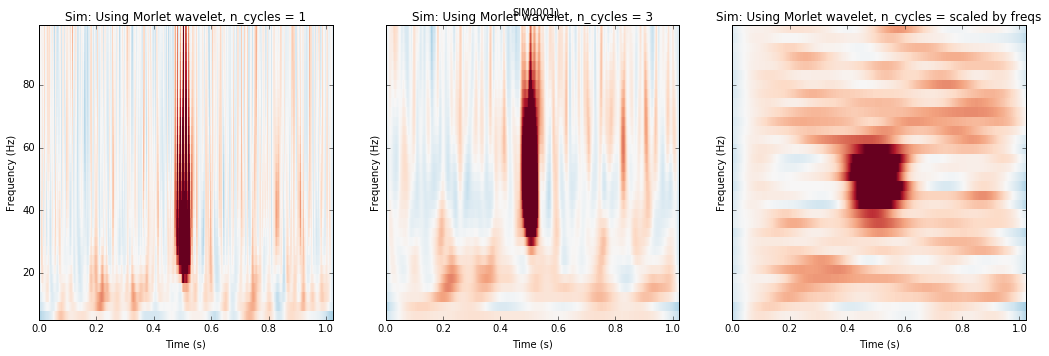

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
all_n_cycles = [1, 3, freqs / 2.]
for n_cycles, ax in zip(all_n_cycles, axs):
    power = tfr_morlet(epochs, freqs=freqs,
                       n_cycles=n_cycles, return_itc=False)
    power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
               axes=ax, show=False, colorbar=False)
    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title('Sim: Using Morlet wavelet, n_cycles = %s' % n_cycles)
plt.tight_layout()

### Calculating a TFR without averaging over epochs
It is also possible to calculate a TFR without averaging across trials. We can do this by using average=False. In this case, an instance of mne.time_frequency.EpochsTFR is returned.

<class 'mne.time_frequency.tfr.EpochsTFR'>
Applying baseline correction (mode: mean)


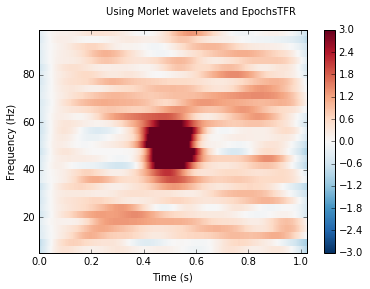

In [51]:
n_cycles = freqs / 2.
power = tfr_morlet(epochs, freqs=freqs,
                   n_cycles=n_cycles, return_itc=False, average=False)
print(type(power))
avgpower = power.average()
avgpower.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
              title='Using Morlet wavelets and EpochsTFR', show=False);

### Operating on arrays (numpy)
- [mne.tfr_array_morlet()](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_array_morlet.html#mne.time_frequency.tfr_array_morlet)
- [mne.tfr_array_multitaper()](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_array_multitaper.html#mne.time_frequency.tfr_array_multitaper)
- [mne.tfr_array_stockwell](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_array_stockwell.html#mne.time_frequency.tfr_array_stockwell)


Applying baseline correction (mode: mean)


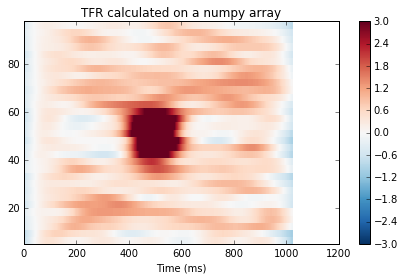

In [52]:
power = tfr_array_morlet(epochs.get_data(), sfreq=epochs.info['sfreq'],
                         freqs=freqs, n_cycles=n_cycles,
                         output='avg_power')
# Baseline the output
rescale(power, epochs.times, (0., 0.1), mode='mean', copy=False)
fig, ax = plt.subplots()
mesh = ax.pcolormesh(epochs.times * 1000, freqs, power[0],
                     cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_title('TFR calculated on a numpy array')
ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
fig.colorbar(mesh)
plt.tight_layout()

plt.show()

## 自定义时间段进行时频分析

In [2]:
import numpy as np
import mne
from mne.datasets import sample
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
print(raw_fname)

/Users/reallo/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


Opening raw data file /Users/reallo/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


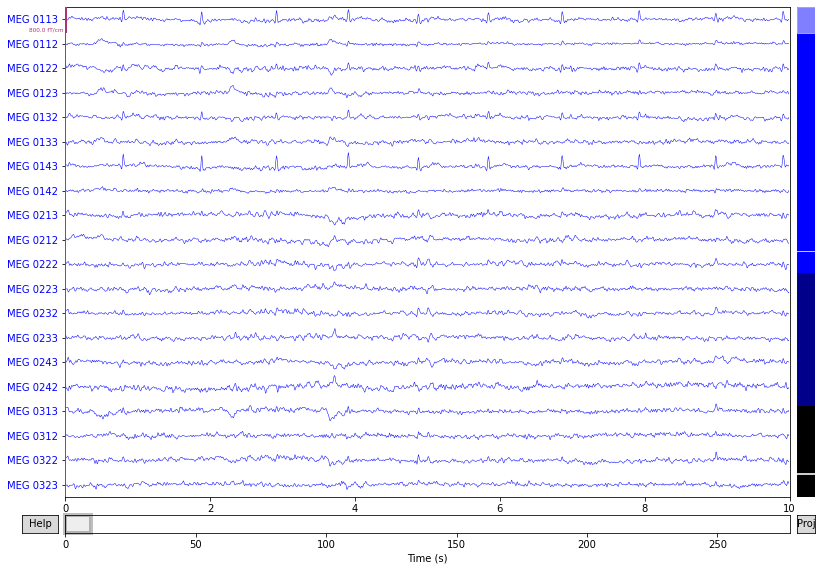

In [68]:
raw = mne.io.read_raw_fif(raw_fname)
print(raw.info)
raw.plot();

In [128]:
# 抽取单通道的指定范围的时间段（1，1，n_times）<---(n_epochs, n_channels, n_times)：

# picks = mne.pick_types(raw.info,meg=True,selection=['MEG 0121'])
# data = raw.get_data(picks=picks,start=0,stop=20)

data = raw.copy().crop(100,105) # select by second
data.pick_channels(['MEG 0143'])
print(data)
# expand dims
tf_data = data.get_data()
tf_datas = np.expand_dims(tf_data,axis=0) #(1,1,301)


Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
<Raw | sample_audvis_filt-0-40_raw.fif, 1 x 752 (5.0 s), ~2.9 MB, data not loaded>


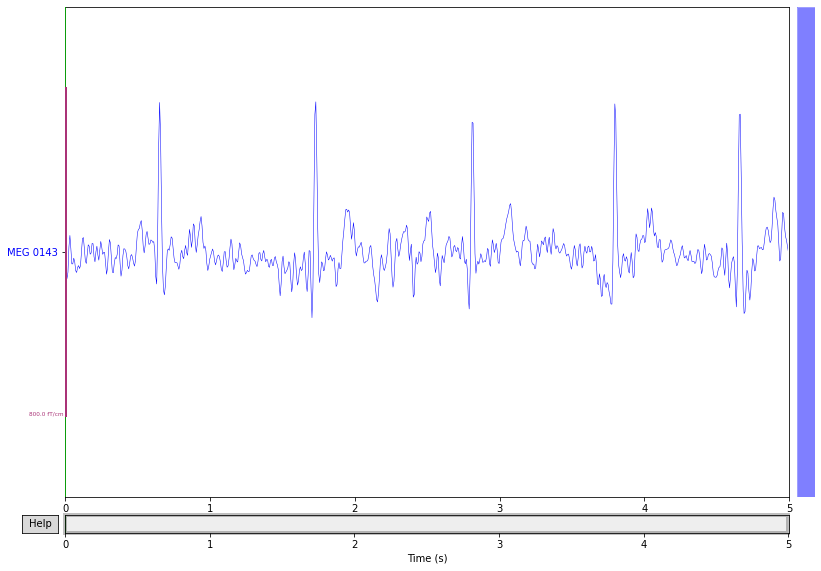

In [129]:
data.plot();

freqs: [ 0.1  3.1  6.1  9.1 12.1 15.1 18.1 21.1 24.1 27.1 30.1 33.1 36.1 39.1
 42.1 45.1 48.1 51.1 54.1 57.1 60.1 63.1 66.1 69.1 72.1]
Applying baseline correction (mode: mean)


<ipython-input-133-19f631f9c88f>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(data.times, freqs, power[0],


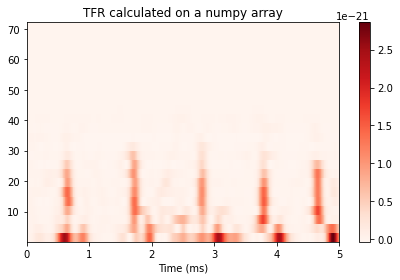

In [133]:
# define frequencies of interest
freqs = np.arange(0.1,raw.info['sfreq']/2, 3.)
# different number of cycle per frequency
n_cycles = freqs / 2.
print("freqs:",freqs)
vmin,vmax = -3.,3. # Define our color limits.

power = tfr_array_morlet(tf_datas, sfreq=raw.info['sfreq'],
                         freqs=freqs, n_cycles=n_cycles,
                         output='avg_power')


# Baseline the output
rescale(power, tf_datas.shape[2], (0.,tf_datas.shape[2] ), mode='mean', copy=False)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(data.times, freqs, power[0],
                     cmap='Reds', vmin=np.min(power[0]), vmax=np.max(power[0])) #RdBu_r
ax.set_title('TFR calculated on a numpy array')
ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
fig.colorbar(mesh)
plt.tight_layout()

plt.show()

In [132]:
power.shape

(1, 25, 752)

### Reference
- https://martinos.org/mne/stable/auto_examples/time_frequency/plot_time_frequency_simulated.html#sphx-glr-auto-examples-time-frequency-plot-time-frequency-simulated-py